In [1]:
import os
import configparser
import random

import PIL.Image

from typing import Any
from pydantic import BaseModel, Field

import google.generativeai as genai
import vertexai
from vertexai.preview.vision_models import ImageGenerationModel, GeneratedImage
from vertexai.preview.vision_models import Image as vertexImage

/Users/suvz47/Code/VSCode/bigbasket_promo_generator/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')
api_key = config['credentials']['gemini_api_key']
proj_id = config['credentials']['gcp_project_id']

In [3]:
# Enter details here
info = {"PROJECT_ID": proj_id, "LOCATION" : "us-central1", "API_KEY" : api_key}


In [4]:
class BannerGenerator(BaseModel):
  """This class will be responsible for endpoints related to Image Generation mechanism"""

  CONFIGS: dict
  topic: str
  images: list | None = Field(default=None)
  text_model: str = "gemini-1.5-flash"
  image_model: str = "imagen-3.0-generate-001"
  edit_model: str = "imagegeneration@006"
  # image_model: str = "imagen-3.0-fast-generate-001"
  pm: Any = None
  im: Any = None
  em: Any = None
  text_v0: str = None
  text_v1: str = None
  text_v2: str = None
  text_v3: str = None
  img_response_v1: Any = None
  img_response_v2: Any = None
  img_response_v3: Any = None
  launch_state: bool = False

  def __launch(self):
    if self.launch_state is False:
      vertexai.init(project=self.CONFIGS['PROJECT_ID'], location=self.CONFIGS['LOCATION'])
      genai.configure(api_key = self.CONFIGS['API_KEY'])
      self.pm = genai.GenerativeModel(self.text_model)
      self.im = ImageGenerationModel.from_pretrained(self.image_model)
      self.em = ImageGenerationModel.from_pretrained(self.edit_model)
      self.launch_state = True
      print("Model Launch successful!")

  def extract_image_information(self):

    self.__launch()

    images = [PIL.Image.open(image_path) for image_path in self.images]
    model = self.pm
    extraction_prompt = '''Examine the set of images to provide concise unique insights about content, color, banner size and product (name, logo, tagline, size and packaging) in less than 150 words'''
    model_input = [extraction_prompt]
    model_input.extend(images)
    response = model.generate_content(model_input)
    print("Attached images examined!")
    return response.text

  def extract_information(self):

    self.__launch()

    # Information Gathering
    out_text = f"""Deep analyze text from retail advertising, marketing psychology and thoroughly researched marketing studies perspective: {self.topic}
    Extract the following information:
    0. Product: Product name, brand and supplier, logo, tagline, size, packaging if available
    1. Objective: 1 word for primary goal of the banner. Example - Awareness, Engagement, Conversion, Branding
    2. Age: The target age group. Example - 'Below 18', '18-25', '25-40', '40-60', '60+'
    3. Gender: Gender preference if applicable. Example - MALE, FEMALE, NON BINARY, ALL
    4. Festival: Event or occasion it may be tied to. Example - Christmas, Diwali, Black Friday, Summer Sale, New Year, Generic
    5. Headline: Suggest a main text that captures attention. Example - Discover [product] for [festival], Shop now and save!, Limited time offer, Innovate your life with [product]
    6. Subheadline: Optional additonal supporting information to clarify the offer. Example - Get 50% off until [date], Exclusive deal for festive season, Hurry offer ends soon
    7. CTA: Add a call to action. Example - Buy now, Shop the collection, Discover More, Sign up today
    8. Color Scheme: Use color palette based on audience, occasion, or product tone. Example - Red & Gold (Festive, Urgency), Blue & White (Trust, Calm), Green & Brown (Eco-friendly, Natural), Black & White (Elegant, Minimal)
    9. Typography: Use font styles that resonate with the target demographic. Example - Sans-serif (Modern, Youthful), Serif (Traditional, Trustworthy), Script (Elegant, Formal), Display fonts (Playful, Bold)
    10. Visual Layout: Use layout pattern to guide user attention. Example - F pattern (Text-heavy), Z pattern (Balanced visuals & text)
    11. Imagery: Use of product images and contextual photos. If provided reuse them else create own. Examples - Multiple product angles, Lifestyle imagery, Holiday-themed images, Close-up product features
    12. Branding: Ensure logo placement and brand consistency. Top-left for logo, Consistent brand colors, Brand slogan or tagline inclusion
    13. Emotional Appeal: Emotion that the banner evokes based on psychographics and event. Example - Nostalgia (Older audiences, festive), Excitement (Younger audiences, sales), Trust and reliability (Product-focused), Aspiration (Luxury goods)
    14. Adaptability: If asked only then ensure banner scales well on mobile and other devices else only website design sizes. Example - Mobile-first design, Large, clear CTA, Minimal text for mobile
    15. Psychographics: Tailor the banner’s design, tone, and visuals based on psychographic factors and set levels for suitable OCEAN traits applicable. Example - [High/Low Openness (Innovation, Creativity): Innovative, creative visuals], [High/Low Conscientiousness (Order, Reliability): Clean, organized layout], [High/Low Extraversion (Vibrancy, Sociability): Bold colors, active themes], [High/Low Agreeableness (Warmth, Trust): Soft tones, community appeal], [High/Low Neuroticism (Stability, Reassurance)]
    16. Region: Location if applicable. Example - USA, London, India, Generic
    17. Specifications: Aspect ratio: 1:7, Resolution: 1360px (width) x 800px (height) (preferable for good resolution)
    18. Ethnicity: Identify target population group that will resonate well with product
    19. Promotional offer: Suggest 1 best promotional offer. Example - MAX ₹99 OFF, UP TO 60% OFF, UNDER ₹999, MIN ₹10 OFF, MIN 20% OFF, STARTS @₹99, FLAT ₹100 OFF, FLAT 20% OFF, ₹499 STORE, BUY 2 GET 1 FREE
    20. Background color gradient: Dynamic color generation to match overall look and feel
    21. Background theme: Festival oriented or generic if no festival

    Capture/modify any relevant extra information from your analysis in above respective buckets or extra buckets if needed.
    """
    self.text_v0 = self.pm.generate_content(out_text).text

    # Information consolidation
    out_text = f"Respond concisely and summarize in python dictionary format only this: {self.text_v0}"
    if self.images:
      image_info = self.extract_image_information()
      out_text += 'Product insights: ' + image_info
      print(f"Product insights:{image_info}")

    self.text_v1 = self.pm.generate_content(out_text).text[9:-5]

    # Scrapper
    out_text = f"Respond concisely by scrapping all unavailable information in python dictionary format only this: {self.text_v1}"
    self.text_v2 = self.pm.generate_content(out_text).text

    print("Information collection complete!")

  def create_text_prompt(self):

    out_text = f"""Task: Fill in the values in this json: {self.text_v2}
    Guidelines:
    1. It will be used to generate an ads banner.
    2. Ensure it has all details pair wise meticulously captured.
    3. All unknown/missing/unprovided variables are replaced with the attributes of most probable shopper for that product.
    4. Recheck and identify all ambiguity or any text that leads to uncertainty.
    5. Replace all uncertainty with targeted values that make most sense for given product.
    6. Quantify everything possible like high, medium and lows to percentage values based on marketing and psychometric research studies.
    7. All KPIs and qualitative measures are to be used subcontextually only. Remove any details about statistical testing or names of any performance KPIs.
    8. Avoid sentences and use only necessary keywords.
    9. Remove all redundant key value pairs.
    """
    self.text_v3 = self.pm.generate_content(out_text).text

    print("Information processed!")

  def generate_image(self):
    prompt = f"""Realistic, subcontextually implied qualitative attributes inspired, excellent image quality ad capturing every detail in json:{self.text_v3}"""
    self.img_response_v1 = self.im.generate_images(prompt=prompt)

    # Save v1
    temp_img_path = 'temp.jpg'
    os.remove(temp_img_path) if os.path.exists(temp_img_path) else None
    self.img_response_v1.images[0].save(temp_img_path)

    print("Image v1 generated!")

  def identify_lags(self):
    prompt = f"""Be direct. Quality check the banner out of 10 on:
    1. Ensure visibility of brand name and logo
    2. Ensure background reflecting brand color consistency
    3. Ensure background if too bland then should be reflecting one of the following: people, culture, geographical, lifestage, product theme
    4. Promotional offer clearly applied and visible
    5. Ensure ALL texts pass grammatical checks
    6. Excellent image quality
    7. Jump up the image resolution if blurred
    8. Background gradient and theme aligned with context
    9. Aspect ratio to 1:7
    10. Resolution to 1360px (width) x 800px (height)
    11. Product name clear
    12. Product picture clear
    13. Product size clear if available
    14. Product packaging clear if available
    15. Product tag line clear if available

    Precisely point out errors and corresponding actions to fix image where score is below 8.
    Do not output anything about elements that need no change. Suggest only minute to below average changes not drastic.
    Use this as benchmark: {self.text_v3}
    """
    model = self.pm
    model_input = [prompt, PIL.Image.open('temp.jpg')]
    response = model.generate_content(model_input)
    print(f'Lags identified::{response.text}')
    return response.text

  def fix_image(self, retest: bool = False):
    prompt = f'Realistic, subcontextually implied qualitative attributes inspired, excellent image quality ad by: {self.identify_lags()}'

    model = self.em
    temp_img_path = 'temp.jpg'

    base_image = vertexImage.load_from_file(location=temp_img_path)

    self.img_response_v2 = model.edit_image(
      base_image=base_image,
      prompt=prompt,
      edit_mode="inpainting-insert",
      mask_mode="background"
      )

    print("Image v2 generated!")

    if retest:
      os.remove(temp_img_path) if os.path.exists(temp_img_path) else None
      self.img_response_v2.images[0].save(temp_img_path)

      prompt = f'Realistic, subcontextually implied qualitative attributes inspired, excellent image quality ad edit by: {self.identify_lags()}'

      base_image = vertexImage.load_from_file(location=temp_img_path)

      self.img_response_v3 = model.edit_image(
      base_image=base_image,
      prompt=prompt,
      edit_mode="inpainting-insert",
      mask_mode="background"
      )

      print("Image v3 generated!")


  def display(self):
    print("="*100)
    print(f"Prompt v0: {self.text_v0}")

    print("="*100)
    print(f"Prompt v1: {self.text_v1}")

    print("="*100)
    print(f"Prompt v2: {self.text_v2}")

    print("="*100)
    print(f"Prompt v3: {self.text_v3}")

    print("="*100)
    self.img_response_v1.images[0].show()

    print("="*100)
    self.img_response_v2.images[0].show()

    print("="*100)
    self.img_response_v3.images[0].show()

  def execute(self, QC=False):
    self.extract_information()
    self.create_text_prompt()
    self.generate_image()
    self.fix_image(retest=QC)
    self.display()

Model Launch successful!
Attached images examined!
Product insights:The image showcases a product banner for Britannia's Good Day Pista Badam cookies. The banner is dominated by a vibrant green color, with a yellow banner at the top featuring the "BUY 4 GET 1 EXTRA" promotion. The product is depicted in a close-up with a focus on the cookie's texture and ingredients. The "Good Day" logo is prominently displayed in a green and white font, with a tagline "Pista Badam Cookies" beneath it. The packaging appears to be a plastic pouch, ideal for individual consumption or small snacking. 

Information collection complete!
Information processed!
Image v1 generated!
Lags identified::4/10

- **Promotional offer clearly applied and visible:** The banner is missing the promotional offer.
    - **Action:** Add a banner across the top or bottom of the image clearly stating the promotional offer, like "10% off Good Day Pista Badam Cookies!"
- **Background theme aligned with context:** The background 

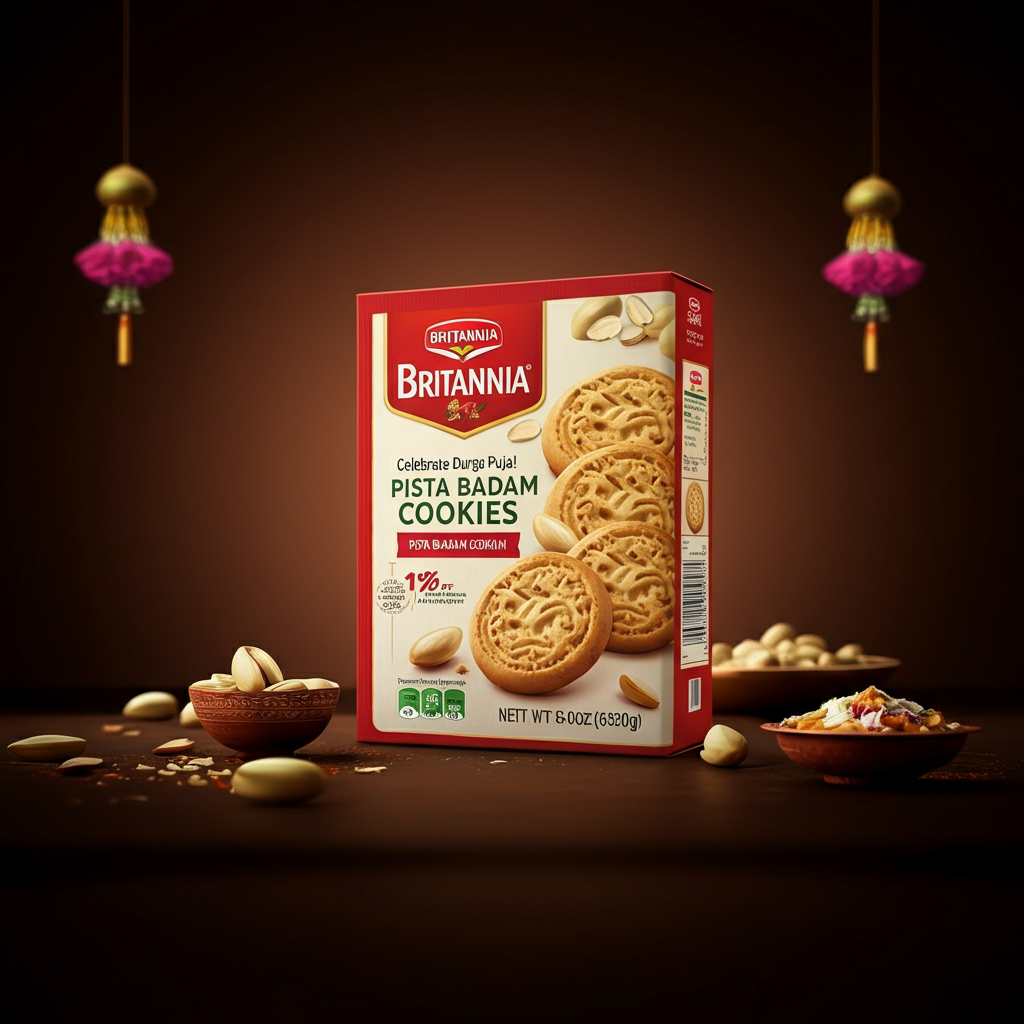

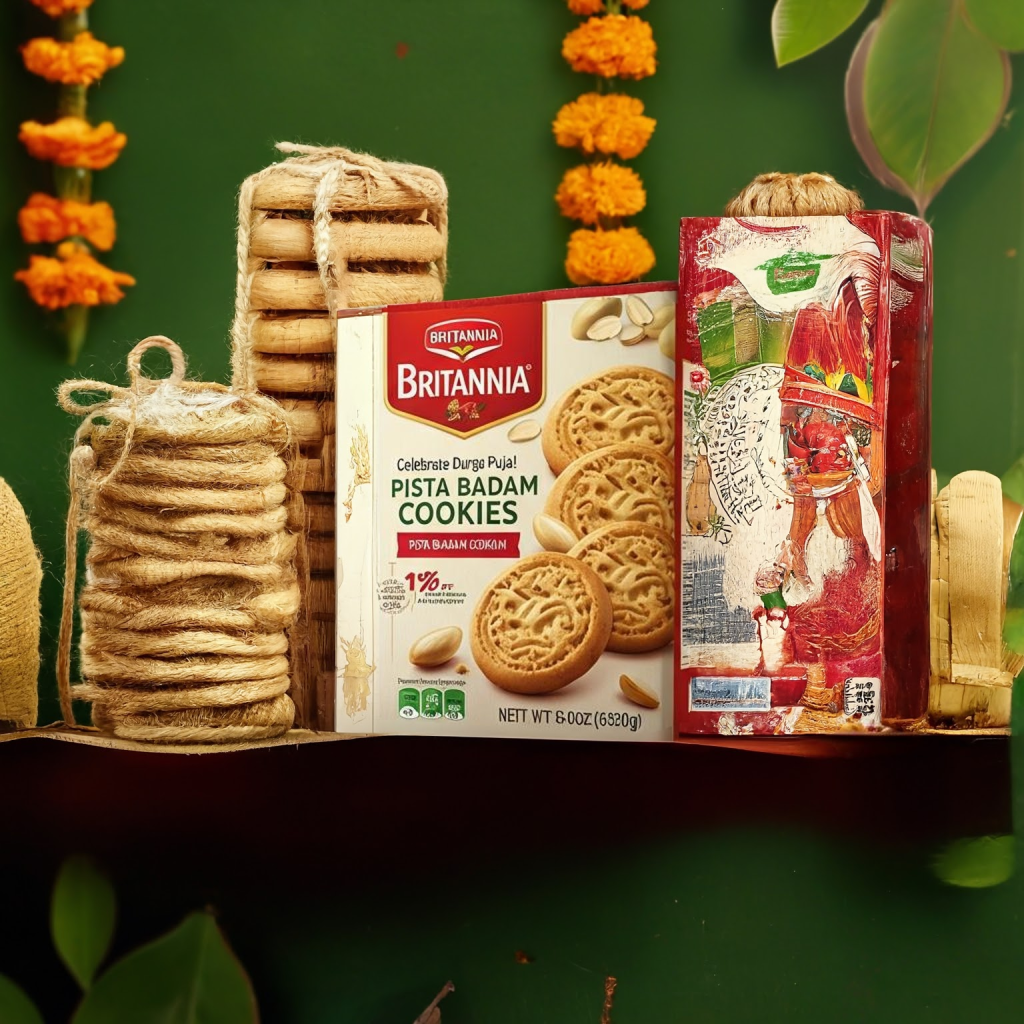

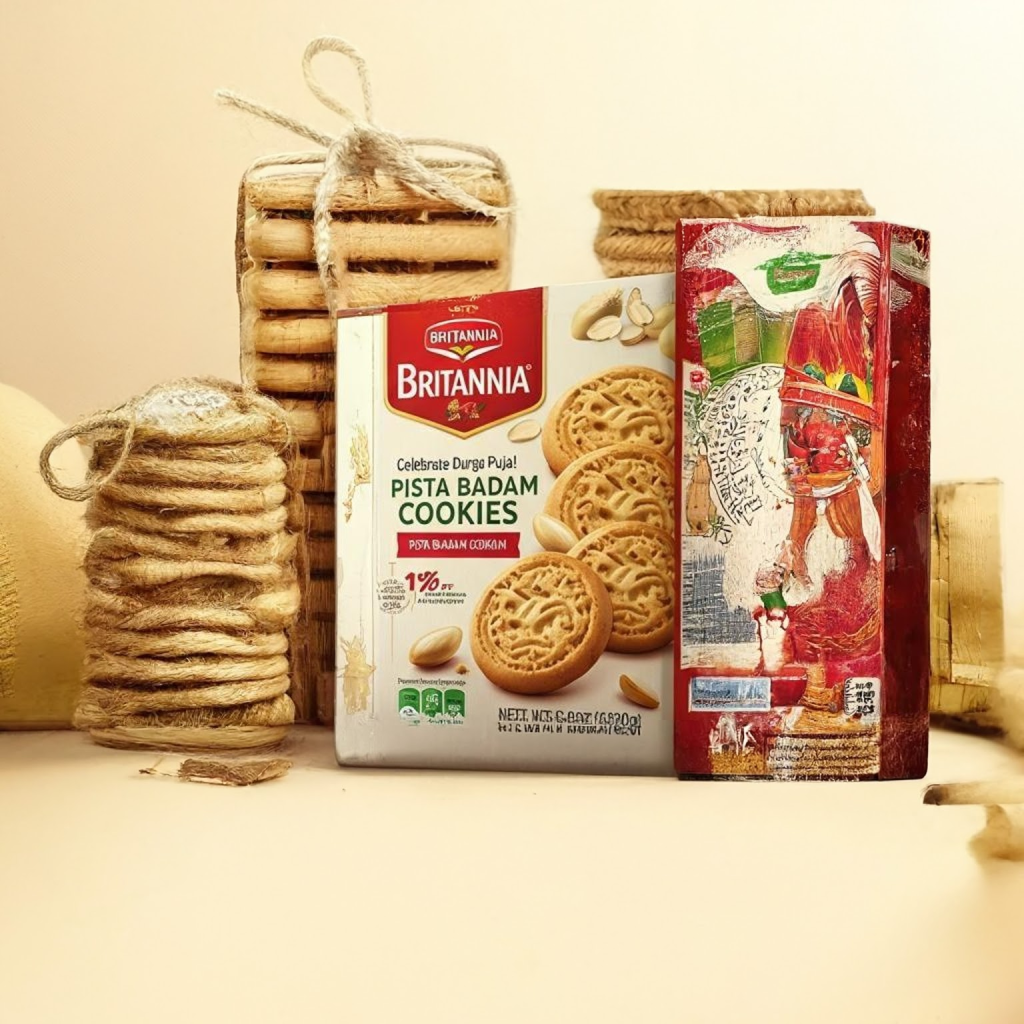

In [6]:
obj = BannerGenerator(CONFIGS = info, topic = "10 percent discount for durga puja", images=['/Users/suvz47/Code/VSCode/bigbasket_promo_generator/images/sample/biscuit_input/biscuit_front.jpg'])
obj.execute(QC=True)